# Dataset evaluation using GAME validation scores for prompts.

## Imports & Dependencies

Load all required libraries for dataset processing, translation, and semantic evaluation. You won't be needing any specialized hardware for this notebook.

In [2]:
import os
import time
import re
import string
import pandas as pd
from tqdm import tqdm
from google import genai
from sentence_transformers import util
from datasets import load_dataset, Dataset
from concurrent.futures import ThreadPoolExecutor, as_completed

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating a checkpoint folder for saving checkpoints of processed prompts.
This lets us resume the augmentation pipeline without re-running completed prompts.

In [ ]:
# mkdir checkpoint/ # Commented out since the folder already exists

## Model & Translator Initialization

1. **`SentenceTransformer('all-MiniLM-L6-v2')`**  
   - Used for back-translation → embeddings → **GAME** semantic fidelity (Sec. 3.3).  
2. **Gemini Translator** (`genai`)  
   - Handles matrix-language translation, dictionary construction, and romanization (Sec. 3.2).
   - Use your gemini api key to access gemini api.

In [4]:
# Load Sentence Transformer model for semantic similarity
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

# Initialize Gemini Translator

client = genai.Client(api_key="api_key")

Default backtranslation prompt used for gemini. 

In [ ]:
def get_prompt(processed_cand_cm_romanized, matrix_lang_code):
    pmt = f"""I will give you a text in {matrix_lang_code} and english below:-
------------------------
{processed_cand_cm_romanized}
------------------------
you have to follow these steps below to translate the text into english.
1. First translate the sentence exactly into non roman {matrix_lang_code} representation of characters.
2. Now translate the sentence into its english translation and remember it as SE.
3. Now for the sentences that are english words and are common in both the SE in step 2 and the original text, POS tag them.
4. Now remembering the POS tags of words, translate the original sentence into {matrix_lang_code} remembering the meaning of POS words and cross-language homonyms.
5. Now translate the final {matrix_lang_code} sentence in step 4 to its english translation.

Only give me the translated sentence in step 5 as your response in this template below so that i can extract the sentence using regular expression
*****Final Translated Sentence*****
[put the final sentence from step 5.]
*****End*****
"""
    return pmt

model_name = "gemini-2.0-flash-lite"

## Utility Functions

This cell defines core helper routines used in the **GAME** semantic-fidelity pipeline (Sec. 3.3) and the validation prompt format (App. 8.4) in *CodeMixBench*

---

### `preprocess(text)` 
- Strip out code fences (```…```)  
- Lowercase, remove punctuation, collapse whitespace  

---

### `extract_translated_sentence(text)`
- Extract the “Final Translated Sentence” from the LLM’s back-translation output using the markers  
    ```
    *****Final Translated Sentence*****
    …text…
    *****End*****
    ``` 

---

### `get_semantic_similarity(text1, text2)`
- Encode inputs via `SentenceTransformer` (all-MiniLM-L6-v2)  
- Compute cosine similarity, clamped to [–1, 1] 
---

### `log_error(entry, msg)`
- Print or persist any errors encountered during evaluation (e.g., parsing or model failures) 


In [13]:
# --- Utility Functions ---
def preprocess(text):
    if not isinstance(text, str):
        return ""
    
    # Remove any ```code fences``` including multiline content
    code_block_pattern = r'```.*?```'
    text = re.sub(code_block_pattern, '', text, flags=re.DOTALL)

    # Convert to lowercase for consistent embedding behavior
    text = text.lower()

    # Remove all punctuation characters
    text = text.translate(str.maketrans('', '', string.punctuation))
    return re.sub(r'\s+', ' ', text).strip()

def extract_translated_sentence(text):
    """
    Extract the back-translated English sentence from the LLM output.
    Looks for markers:
      *****Final Translated Sentence*****
      ...sentence...
      *****End*****
    Returns None if the pattern is not found.
    """

    pattern = r"\*{5}Final Translated Sentence\*{5}\s*(.*?)\s*\*{5}End\*{5}"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(1).strip() if match else None

def get_semantic_similarity(text1, text2):
    """
    Compute cosine similarity between two texts using a SentenceTransformer model.
    - Returns 0.0 if either input is empty or on any error.
    - Clamps similarity to the range [-1.0, 1.0].
    """
    if not text1 or not text2:
        return 0.0
    try:
        # Encode and normalize embeddings
        emb1 = similarity_model.encode(text1, convert_to_tensor=True, normalize_embeddings=True)
        emb2 = similarity_model.encode(text2, convert_to_tensor=True, normalize_embeddings=True)
        # Compute cosine similarity
        sim = util.pytorch_cos_sim(emb1, emb2)
        
        return max(-1.0, min(1.0, sim.item()))
    except Exception as e:
        print(f"Similarity Calculation Error: {e}")
        return 0.0

def log_error(entry, msg):
    # with open(ERROR_LOG_FILE, "a", encoding="utf-8") as f:
    #     f.write(json.dumps({"error": msg, "entry": entry}, ensure_ascii=False) + "\n")
    print({"error": msg, "entry": entry})


## GAME Evaluation Class

Implements the **GAME** semantic-fidelity metric pipeline (Sec. 3.3) from *CodeMixBench*

In [ ]:
class GAME:
    """
    Implements the GAME (Gold-standard Agnostic Measure for Evaluation) semantic-fidelity pipeline.
    Back-translates a romanized code-mixed prompt to English and computes cosine similarity
    against the original English reference, returning a score in [0, 100].
    """

    def __init__(self, matrix_lang_code='hindi'):
        """
        Args:
            matrix_lang_code (str): Code of the matrix language used in the prompt
                                    (e.g. 'hindi', 'spanish', 'chinese').
        """
        # Store the target language for constructing the back-translation prompt
        self.matrix_lang_code = matrix_lang_code

    def evaluate(self, reference_en, candidate_cm_romanized):
        """
        Perform GAME evaluation for one prompt pair.

        Steps:
          1. Preprocess both reference and candidate to normalize text.
          2. If either is empty after preprocessing, return 0.0 (failure).
          3. Call the translation API to convert the romanized candidate back to English.
          4. Extract the “Final Translated Sentence” from the API response.
          5. If extraction fails, return 0.0.
          6. Compute embedding-based cosine similarity.
          7. Scale to percentage (0–100) and return.

        Returns:
            float: GAME score (0–100). Zero on any error or missing data.
        """
        try:
            processed_ref = preprocess(reference_en)
            processed_cand = preprocess(candidate_cm_romanized)

            if not processed_ref or not processed_cand:
                return 0.0

            # Generate back-translation via the LLM
            response = client.models.generate_content(
                model=model_name, contents=get_prompt(processed_cand, self.matrix_lang_code)
            )

            # Parse out the translated sentence from the response
            reconstructed = extract_translated_sentence(response.text)
            if not reconstructed:
                return 0.0

            # Compute semantic similarity between original and back-translated text
            sim_score = get_semantic_similarity(processed_ref, reconstructed)
            
            # Return similarity as a percentage
            return max(0.0, sim_score) * 100

        except Exception as e:
            return 0.0

In [ ]:

# --- Main Execution with Checkpoint and Rate Limiting ---
def compare_datasets_with_checkpointing(dataset_en_path, dataset_cm_path, matrix_lang, split='train'):
    ds_en = load_dataset(dataset_en_path, split="v0.1.4")
    
    ds_cm = pd.read_parquet(dataset_cm_path)

    if os.path.exists(CHECKPOINT_FILE):
        checkpoint_df = pd.read_parquet(CHECKPOINT_FILE)
        processed_indices = set(checkpoint_df['index'])
    else:
        checkpoint_df = pd.DataFrame(columns=['index', 'score'])
        processed_indices = set()

    all_scores = []
    failed = 0
    game = GAME(matrix_lang)

    indices = [i for i in range(len(ds_cm)) if i not in processed_indices]
    progress_bar = tqdm(total=len(indices), desc="Processing Entries")
    elapsed_times = []

    for i in range(0, len(indices), BATCH_SIZE):
        batch_indices = indices[i:i+BATCH_SIZE]
        start_time = time.time()

        with ThreadPoolExecutor(max_workers=BATCH_SIZE) as executor:
            futures = {
                executor.submit(
                    game.evaluate,
                    ds_en[j]['instruct_prompt'],
                    
                    ds_cm.iloc[j]['instruct_prompt']
                ): j for j in batch_indices
            }

            for future in as_completed(futures):
                j = futures[future]
                try:
                    score = future.result()
                    all_scores.append(score)
                    checkpoint_df.loc[len(checkpoint_df)] = {'index': j, 'score': score}
                    checkpoint_df.to_parquet(CHECKPOINT_FILE, index=False)
                    progress_bar.update(1)
                except Exception as e:
                    log_error({'index': j}, f"Evaluation Error: {e}")
                    failed += 1

        # Enforce rate limiting
        elapsed = time.time() - start_time
        sleep_time = max(0, ONE_MINUTE - elapsed)
        if sleep_time > 0:
            print(f"Waiting {sleep_time:.2f} seconds before next batch...")
            time.sleep(sleep_time)

    progress_bar.close()
    avg_score = sum(all_scores) / len(all_scores) if all_scores else 0.0

    print("\n--- Evaluation Complete ---")
    print(f"Matrix Language: {matrix_lang}")
    print(f"Entries processed: {len(all_scores)}")
    print(f"Failed evaluations: {failed}")
    print(f"Average GAME Score: {avg_score:.2f}")

    return all_scores, avg_score, failed

## Main Execution: Checkpointing & Rate Limiting

This cell orchestrates the **GAME** evaluation over the entire code-mixed dataset, with resume-on-failure via checkpoints and enforced rate limits, following the pipeline described in Sec. 3.2.1 (Implementation Pipeline) and Sec. 3.3 (Semantic Quality Verification) of _CodeMixBench_

In [ ]:
# # --- Configuration ---
# Using the specified HF dataset names
ENGLISH_DATASET_PATH = "bigcode/bigcodebench"
CODE_MIXED_DATASET_PATH = "../dataset/spa-eng/MBigCodeBench-spa-eng-cmd0.9.parquet"
MATRIX_LANGUAGE = "Spanish" 
DATASET_SPLIT = 'train' 

# --- Configuration for Checkpoint and Rate Limiting ---
ONE_MINUTE = 60
BATCH_SIZE = 15
CHECKPOINT_FILE = "checkpoint/game_scores_checkpoint.parquet"
ERROR_LOG_FILE = "checkpoint/game_error_log.txt"

# Define similarity model, model_name, and client before using this code

try:
     game_scores, avg_score, failed_score = compare_datasets_with_checkpointing(
         ENGLISH_DATASET_PATH,
         CODE_MIXED_DATASET_PATH,
         matrix_lang=MATRIX_LANGUAGE,
         split=DATASET_SPLIT,
     )
     # print("\nIndividual Scores:", scores) # Uncomment to see all scores
except FileNotFoundError:
     print("\nError: One or both datasets could not be loaded from Hugging Face Hub.")
     print("Please ensure the dataset identifiers and your internet connection are correct.")
except ValueError as ve:
     print(f"\nValueError during dataset loading or processing: {ve}")
     print("This might indicate an issue with the dataset structure, split name, or configuration name.")
except Exception as e:
     print(f"\nAn unexpected error occurred: {e}")
     # Optionally add more detailed error logging here
     import traceback
     traceback.print_exc()

## Data Visualization


--- Evaluation Summary ---
Matrix Language: Spanish
Number of entries processed: 2
Number of failed/skipped evaluations: 0
Average GAME Score (over all processed): 89.36


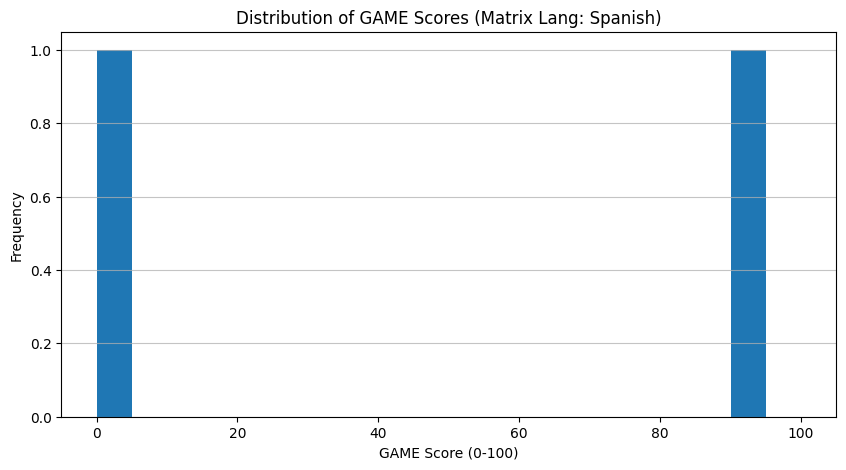

In [23]:
print("\n--- Evaluation Summary ---")
print(f"Matrix Language: Spanish")
print(f"Number of entries processed: {len(game_scores)}")
print(f"Number of failed/skipped evaluations: {failed_score}")
print(f"Average GAME Score (over all processed): {avg_score:.2f}")


try:
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(10, 5))
    plt.hist(np.array(game_scores), bins=20, range=(0, 100)) # Ensure scores are within 0-100 range for plot
    plt.title(f"Distribution of GAME Scores (Matrix Lang: Spanish)")
    plt.xlabel("GAME Score (0-100)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
except ImportError:
    print("\nInstall matplotlib to see the score distribution plot: pip install matplotlib numpy")

In [31]:
df = pd.read_parquet(CHECKPOINT_FILE)
print(df.head(1))

   index      score
0      0  95.747286



--- Evaluation Summary ---
Matrix Language: Spanish
Number of entries processed: 1137
Number of failed/skipped evaluations: 1
Average GAME Score (over all processed): 89.38


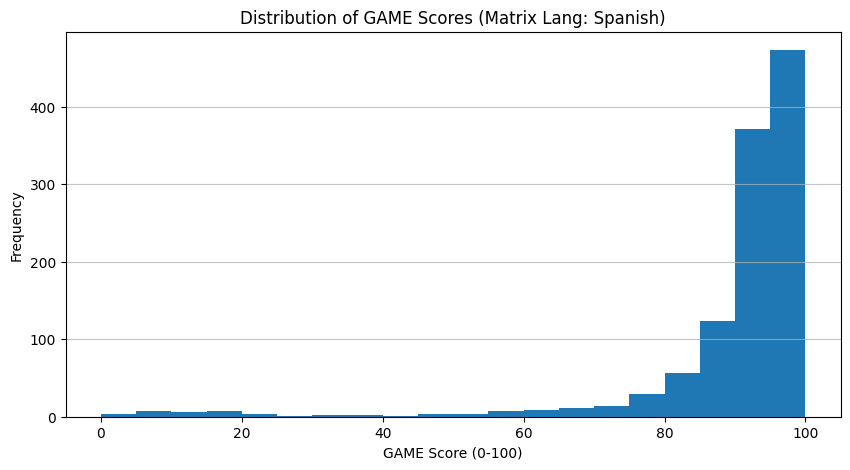

In [32]:
# Calculate values
total_entries = len(df)
failed_score = (df["score"] == 0).sum()
processed_scores = df[df["score"] > 0]["score"]
avg_score = processed_scores.mean()

# Print summary
print("\n--- Evaluation Summary ---")
print(f"Matrix Language: Spanish")
print(f"Number of entries processed: {total_entries}")
print(f"Number of failed/skipped evaluations: {failed_score}")
print(f"Average GAME Score (over all processed): {avg_score:.2f}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(processed_scores, bins=20, range=(0, 100))
plt.title(f"Distribution of GAME Scores (Matrix Lang: Spanish)")
plt.xlabel("GAME Score (0-100)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()


In [33]:
df = df[df['score'] != 0]
len(df)

1136

In [34]:
df.to_parquet(CHECKPOINT_FILE)